In [1]:
%matplotlib inline

import os
import sys
import struct
from time import time

sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import numpy as np
from matplotlib import pyplot as pl

import lalpulsar

In [2]:
# show test of residuals
rundir = '/home/matthew/repositories/greedycpp/scripts/barycenter'

# get time stamps
ts = np.loadtxt(os.path.join(rundir, 'quad_rule.txt'))
t = ts[:,0]

lenb = len(t)

# get number of basis
Nb = np.loadtxt(os.path.join(rundir, 'ApproxErrors.txt')).shape[0]

# read in binary version of reduced basis data
bf = open(os.path.join(rundir,'Basis.bin'), 'rb')
fc = bf.read()
bf.close()

rb = np.zeros((Nb,lenb))
for i in range(Nb):
    tmpvals = struct.unpack('d'*lenb*2, fc[(i*8*lenb*2):(i+1)*8*lenb*2])
    rb[i] = tmpvals[::2] # just get real part

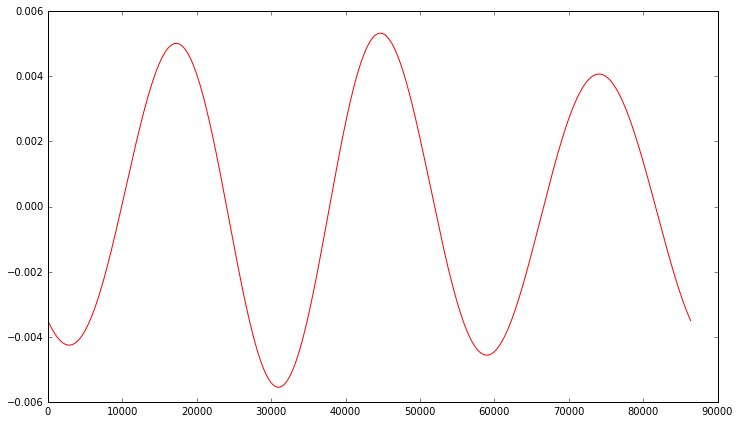

In [3]:
fig, ax = pl.subplots(figsize=(12,7))

ax.plot(t-t[0], rb[6], 'r')

In [4]:
# read in binary version of empirical interpolation matrix
invV = np.zeros((Nb, Nb))
bf = open(os.path.join(rundir,'invV.bin'), 'rb')
fc = bf.read()
bf.close()
for i in range(Nb):
    tmpvals = struct.unpack('d'*Nb*2, fc[(i*8*Nb*2):(i+1)*8*Nb*2])
    invV[i] = tmpvals[::2] # just get real part

# get random binary positions
nbin = 100
maxecc = 0.1
eccs = maxecc*np.random.rand(nbin)
w0 = 2.*np.pi*np.random.rand(nbin)     # uniform from 0 -> 2pi
T0 = np.random.rand(nbin)

deltaTs = np.zeros(lenb)
deltaTsArray = []

par = lalpulsar.PulsarParameters()
period = 86400.
asini = 10.
binarytype = "BT"
lalpulsar.PulsarAddREAL8Param( par, "PB", period )
lalpulsar.PulsarAddREAL8Param( par, "A1", asini )
lalpulsar.PulsarAddStringParam( par, "BINARY", binarytype )

# get deltaTs calculated over all times using LALBarycenter routines
for i in range(nbin):
    # set source sky position
    bininput = lalpulsar.BinaryPulsarInput()
    binoutput = lalpulsar.BinaryPulsarOutput()
    
    lalpulsar.PulsarAddREAL8Param( par, "ECC", eccs[i] )
    lalpulsar.PulsarAddREAL8Param( par, "OM", w0[i] )
    lalpulsar.PulsarAddREAL8Param( par, "T0", t[0]+T0[i]*period )

    # set GPS time
    for j, tv in enumerate(t):
        bininput.tb = tv
        
        # perform binary barycentring
        lalpulsar.BinaryPulsarDeltaTNew( binoutput, bininput, par )
        deltaTs[j] = binoutput.deltaT
    
    deltaTsArray.append(np.copy(deltaTs))

In [5]:
# perform some timing evalution
ts = np.zeros(len(t))

for i in range(len(t)):
    t0 = time()
    bininput.tb = t[i]
        
    # perform binary barycentring
    lalpulsar.BinaryPulsarDeltaTNew( binoutput, bininput, par )
    t1 = time()
    ts[i] = (t1-t0)

print("Total time for evalution = %.9f" % np.sum(ts))
print("time for one evaluation = %.9f" % np.median(ts))

Total time for evalution = 0.008357286
time for one evaluation = 0.000004053


In [10]:
# get deltaTs calculated using interpolant
deltaTsArrayNew = []
dtvals = np.zeros(Nb)

ts_nodes = np.loadtxt(os.path.join(rundir, 'EIM_nodes.txt'))

B = np.einsum('ik,ij->kj', invV, rb)

# get deltats calculated using the reduced basis
for i in range(nbin):
    # set source sky position
    bininput = lalpulsar.BinaryPulsarInput()
    binoutput = lalpulsar.BinaryPulsarOutput()
    
    lalpulsar.PulsarAddREAL8Param( par, "ECC", eccs[i] )
    lalpulsar.PulsarAddREAL8Param( par, "OM", w0[i] )
    lalpulsar.PulsarAddREAL8Param( par, "T0", t[0]+T0[i]*period )
    
    # get values of deltaT at given points
    for j, tv in enumerate(ts_nodes):
        bininput.tb = tv
        
        lalpulsar.BinaryPulsarDeltaTNew( binoutput, bininput, par )
        
        dtvals[j] = binoutput.deltaT

    # create new version of deltaTs using empirical interpolant matrix
    deltaTsArrayNew.append(np.einsum('i,ij->j', dtvals, B))

# time linear algebra
%timeit np.dot(dtvals, B)

The slowest run took 399.21 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.53 µs per loop


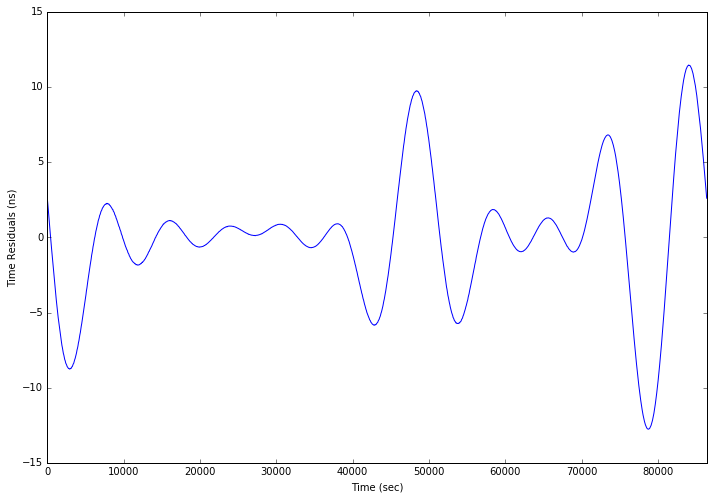

In [12]:
fig, ax1 = pl.subplots(figsize=(10,7))

ax1.plot(t-t[0], (deltaTsArrayNew[0]-deltaTsArray[0])*1e9)

ax1.set_ylabel('Time Residuals (ns)')
ax1.set_xlabel('Time (sec)')
ax1.set_xlim([0., (t[-1]-t[0])])

fig.tight_layout()